<a href="https://colab.research.google.com/github/MohiteYash/baby/blob/main/baby_01_81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install librosa tensorflow numpy pandas matplotlib seaborn scikit-learn


In [2]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm


In [4]:


# Define dataset directory
DATASET_PATH ="/content/drive/MyDrive/Baby_dataset/Baby_crying _Dataset"  # Change this to your actual dataset path


### Function to Extract Mel-Spectrogram


In [5]:
def extract_features(file_path, max_pad_length=128):
    y, sr = librosa.load(file_path, sr=22050)  # Load audio file
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB scale

    # Padding to make all spectrograms same size
    if mel_spec_db.shape[1] < max_pad_length:
        pad_width = max_pad_length - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_spec_db = mel_spec_db[:, :max_pad_length]

    return mel_spec_db


# **Load Dataset & Extract Features**


In [6]:
labels = []
features = []

# Loop through each category folder and extract features
for category in os.listdir(DATASET_PATH):
    category_path = os.path.join(DATASET_PATH, category)

    if os.path.isdir(category_path):  # Ensure it's a folder
        for file_name in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
            file_path = os.path.join(category_path, file_name)
            if file_path.endswith(".wav"):
                mel_spec = extract_features(file_path)
                features.append(mel_spec)
                labels.append(category)

# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Encode labels (convert text to numbers)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split dataset into train & test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels_categorical, test_size=0.2, random_state=42)

# Reshape data for CNN input (Add channel dimension)
X_train = X_train.reshape(X_train.shape[0], 128, 128, 1)  # (samples, height, width, channels)
X_test = X_test.reshape(X_test.shape[0], 128, 128, 1)

print("Dataset Loaded Successfully! ✅")


Processing tired: 100%|██████████| 24/24 [00:09<00:00,  2.62it/s]

Dataset Loaded Successfully! ✅


# **Build Deep Learning Model (CNN)**


In [7]:
# Build CNN Model
model = Sequential([
    # First Convolutional Layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Layer
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Layer
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten & Fully Connected Layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output Layer
])

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print Model Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,549,893 (24.99 MB)

 Trainable params: 6,549,445 (24.98 MB)

 Non-trainable params: 448 (1.75 KB)

# **Train the Model**

In [8]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 582ms/step - accuracy: 0.5601 - loss: 5.4768 - val_accuracy: 0.8152 - val_loss: 13.3721
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6842 - loss: 3.6628 - val_accuracy: 0.8152 - val_loss: 11.4802
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7717 - loss: 2.2970 - val_accuracy: 0.8152 - val_loss: 11.9942
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6961 - loss: 2.5197 - val_accuracy: 0.8152 - val_loss: 9.6759
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7260 - loss: 1.8844 - val_accuracy: 0.8152 - val_loss: 3.5288
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7040 - loss: 2.3241 - val_accuracy: 0.8152 - val_loss: 2.5314
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7255 - loss: 1.0697 - val_accuracy: 0.8152 - val_loss: 3.2572
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7647 - loss: 1.0695 - val_accuracy: 0.815

# **MODEL Evaluation **

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8334 - loss: 1.1589
Test Accuracy: 81.52%


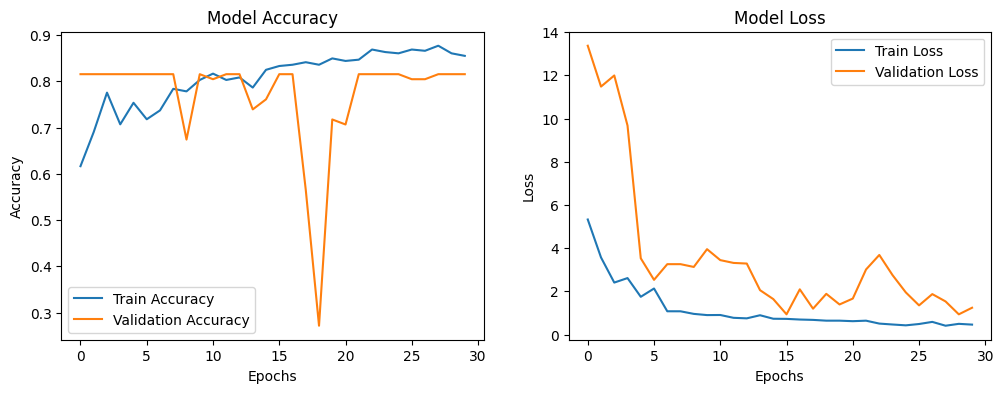

In [9]:
# Evaluate Model Performance
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")

plt.show()


In [10]:
model.save("/content/drive/MyDrive/baby_cry_classifier_81.h5")
